# Bismillah...!
## This is the code for Digital Signature Modeling of Driving Behaviour for Data Privcy preserving and Driver Identification.




1.   Data for drivers from A-F is available and we have modeled a digital twin that captures the 6 most distinct features of the OBE signals obtained form vehicle.   
2.   The model takes as input the OBS data features and Driver and Time context within vehicle it learns the driving patterens and signal dynamics.


1.   Later at cloud it only uses the trained model and given the driver context and time. The model generates the signals exteactly ontained from driver.  
2.   The model trained is CVAE.


1.   Contribution: There are two previous studies on this dataset one has simple classification of drivers and other is also similar but with different feature counts. (Attacth the Links of papers for Misha reference)
2.   Our digital twin is providing the vehicle a classifier that is trilored for the specific driver and it does not directly use the dataset generated from the vehicle. Learns the latent space and shared the model with the cloud. The cloud/digital twin trains the classifier by providing a random normal distribution for 6 signals and driver and time context. This generates a patteren of the driver.


1.   This classifier is passed back to the vehicle. Where at the edge it provides classification scores.
2.   Current Experiment has trained CVAEs with different hyperparameters, and Classifiers on data generated from the CVAEs. Where CVAE with contrastive loss provides better driver distinction.


1.   A classifier must also be trained on real dataset as a reference.











⚙️ Using device: cuda
Epoch 001: Train=1.02407 | Val=1.01020 | Contrastive=0.17759
  ✅ Improved model saved at epoch 1
Epoch 002: Train=0.98173 | Val=0.97398 | Contrastive=0.07244
  ✅ Improved model saved at epoch 2
Epoch 003: Train=0.95909 | Val=0.93594 | Contrastive=0.08675
  ✅ Improved model saved at epoch 3
Epoch 004: Train=0.94604 | Val=0.94813 | Contrastive=0.15858
Epoch 005: Train=0.92922 | Val=0.95607 | Contrastive=0.39713
Epoch 006: Train=0.89640 | Val=0.96844 | Contrastive=0.60942
Epoch 007: Train=0.83396 | Val=0.96543 | Contrastive=0.65068
Epoch 008: Train=0.72623 | Val=0.96121 | Contrastive=0.53226
Epoch 009: Train=0.62641 | Val=0.93265 | Contrastive=0.43143
  ✅ Improved model saved at epoch 9
Epoch 010: Train=0.56703 | Val=0.90032 | Contrastive=0.35607
  ✅ Improved model saved at epoch 10
Epoch 011: Train=0.52987 | Val=0.87213 | Contrastive=0.31547
  ✅ Improved model saved at epoch 11
Epoch 012: Train=0.50292 | Val=0.86583 | Contrastive=0.28978
  ✅ Improved model saved at 

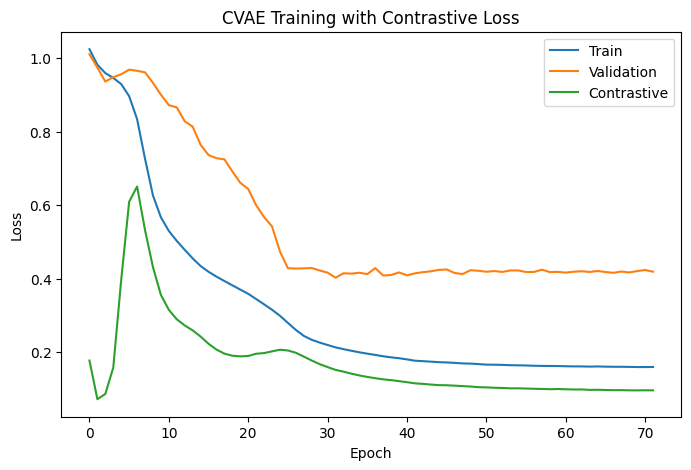


===== DRIVER SIGNATURES =====

Driver B Signature:
[-0.01237759 -0.0232906   0.0365723   0.02381518 -0.00166217  0.04491897
 -0.04847746 -0.009024    0.021684   -0.03836232 -0.0347801  -0.04716443
  0.04587522 -0.00839829 -0.01074857  0.00659997 -0.0044006   0.05891842
  0.00460702  0.04619217 -0.0509575   0.02366524  0.00771995 -0.02416634
 -0.03086693 -0.05195146  0.00086803 -0.05443526 -0.00355543 -0.04476018
  0.02762     0.05400931  0.05694566 -0.04759229  0.00545496  0.06174442
  0.02254635 -0.03929031 -0.03901285 -0.04309788  0.04483883 -0.0104405
 -0.01513704  0.0389909  -0.01049246  0.03854362 -0.00608601  0.00597146
  0.02274985 -0.06625977  0.03697695  0.03497132 -0.0004179   0.05834771
 -0.00173676 -0.03135379  0.03501591 -0.01256232 -0.00987989  0.05338026
  0.02850805 -0.04828117 -0.02414377 -0.05032875  0.00843823 -0.05318488
 -0.01725011 -0.05017353  0.00749147 -0.0063499   0.06070985  0.04255783
 -0.07016303 -0.03049715 -0.02848403 -0.02508939  0.04335354  0.01605866


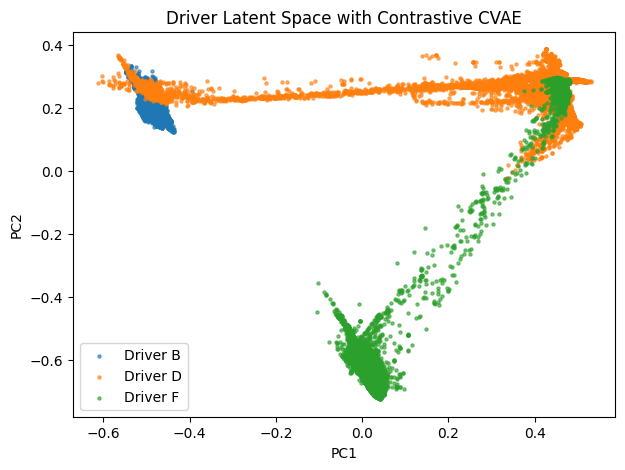

In [ ]:
# ============================================
# 🚗 Conditional Variational Autoencoder (CVAE)
# with Class-Conditional Loss and KPI Analytics
# ============================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time, copy, os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from numpy import dot
from numpy.linalg import norm
from itertools import combinations

# ====== DEVICE ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Using device: {device}")

# ====== MODEL ======
class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=256, condition_dim=0, hidden=128, dropout=0.2):
        super().__init__()
        # ----- Encoder -----
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden, latent_dim)
        self.fc_logvar = nn.Linear(hidden, latent_dim)

        # ----- Decoder -----
        self.decoder_input = nn.Linear(latent_dim + condition_dim, hidden)
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, input_dim)
        )

    def encode(self, x, c):
        h = self.encoder(torch.cat([x, c], dim=1))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        zc = torch.cat([z, c], dim=1)
        h = self.decoder_input(zc)
        return self.decoder(h)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, c)
        return recon, mu, logvar


# ====== LOSS FUNCTIONS ======
def loss_function(recon_x, x, mu, logvar):
    rec_loss = F.mse_loss(recon_x, x, reduction='mean')
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return rec_loss + kl, rec_loss, kl


def contrastive_loss(mu, labels, margin=1.0):
    """Contrastive loss: same driver → close, diff drivers → apart."""
    dist = torch.cdist(mu, mu, p=2)
    same_class = (labels.unsqueeze(1) == labels.unsqueeze(0)).float()
    diff_class = 1.0 - same_class

    pos_loss = (same_class * dist.pow(2)).sum() / (same_class.sum() + 1e-6)
    neg_loss = (diff_class * F.relu(margin - dist).pow(2)).sum() / (diff_class.sum() + 1e-6)
    return pos_loss + neg_loss


# ====== INITIALIZE MODEL ======
input_dim = X_train.shape[1]
condition_dim = C_train.shape[1]
latent_dim = 256
hidden_dim = 128
dropout = 0.15

model = CVAE(input_dim, latent_dim, condition_dim, hidden_dim, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)

# ====== DRIVER LABELS ======
le = LabelEncoder()
driver_labels = le.fit_transform(df_all['Driver'])
driver_tensor = torch.tensor(driver_labels, dtype=torch.long).to(device)

# ====== MOVE DATA TO GPU ======
X_train = X_train.to(device)
C_train = C_train.to(device)
X_val = X_val.to(device)
C_val = C_val.to(device)


# ====== TRAIN FUNCTION ======
def train_cvae(model, X, C, X_val, C_val, driver_tensor, epochs=800, batch_size=128, patience=10,
               checkpoint_path="/content/drive/MyDrive/DigitalTwinDataset/best_cvae.pt"):
    n = X.shape[0]
    best_val_loss = np.inf
    best_wts = copy.deepcopy(model.state_dict())
    history = {"train": [], "val": [], "contrastive": []}
    start_time = time.time()
    no_improve = 0

    for epoch in range(1, epochs + 1):
        model.train()
        perm = torch.randperm(n)
        epoch_loss, epoch_contrastive = 0, 0

        for i in range(0, n, batch_size):
            idx = perm[i:i + batch_size]
            xb, cb, lbl = X[idx], C[idx], driver_tensor[idx]
            recon, mu, logvar = model(xb, cb)
            base_loss, rec, kl = loss_function(recon, xb, mu, logvar)
            closs = contrastive_loss(mu, lbl, margin=1.0)
            total_loss = base_loss + 0.15 * closs

            optimizer.zero_grad(set_to_none=True)
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item() * len(idx)
            epoch_contrastive += closs.item() * len(idx)

        epoch_loss /= n
        epoch_contrastive /= n

        # Validation
        model.eval()
        with torch.no_grad():
            recon_v, mu_v, logvar_v = model(X_val, C_val)
            val_loss, _, _ = loss_function(recon_v, X_val, mu_v, logvar_v)

        scheduler.step(val_loss)
        history["train"].append(epoch_loss)
        history["val"].append(val_loss.item())
        history["contrastive"].append(epoch_contrastive)

        print(f"Epoch {epoch:03d}: Train={epoch_loss:.5f} | Val={val_loss.item():.5f} | Contrastive={epoch_contrastive:.5f}")

        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_wts = copy.deepcopy(model.state_dict())
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            torch.save(best_wts, checkpoint_path)
            print(f"  ✅ Improved model saved at epoch {epoch}")
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"\n⏹️ Early stopping after {epoch} epochs (no improvement for {patience})")
            break

    model.load_state_dict(best_wts)
    duration = (time.time() - start_time) / 60
    print(f"\n🏁 Training complete in {duration:.2f} minutes on {device}. Best Val Loss: {best_val_loss:.5f}")

    # Training plots
    plt.figure(figsize=(8,5))
    plt.plot(history["train"], label="Train")
    plt.plot(history["val"], label="Validation")
    plt.plot(history["contrastive"], label="Contrastive")
    plt.legend(); plt.title("CVAE Training with Contrastive Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.show()
    return model


# ====== TRAIN MODEL ======
model = train_cvae(
    model, X_train, C_train, X_val, C_val, driver_tensor,
    epochs=800, batch_size=128, patience=40,
    checkpoint_path="/content/drive/MyDrive/DigitalTwinDataset/best_cvae_256.pt"
)


# ====== DRIVER SIGNATURES ======
model.eval()
driver_signatures = {}
with torch.no_grad():
    for d in drivers:
        mask = df_all['Driver'] == d
        Xd = torch.tensor(X_main[mask], dtype=torch.float32).to(device)
        Cd = torch.tensor(context[mask], dtype=torch.float32).to(device)
        mu, _ = model.encode(Xd, Cd)
        driver_signatures[d] = mu.mean(dim=0).cpu().numpy()

print("\n===== DRIVER SIGNATURES =====")
for d, sig in driver_signatures.items():
    print(f"\nDriver {d} Signature:\n{sig}")


# ====== VALIDATION TEST + KPI ======
print("\n🔬 Validation Test & KPI Analysis:")
mse_list, sim_list = [], []
for d in drivers:
    mask_val = (df_all['Driver'] == d) & (df_all['Split'] == 'Valid')
    Xd = torch.tensor(X_main[mask_val], dtype=torch.float32).to(device)
    Cd = torch.tensor(context[mask_val], dtype=torch.float32).to(device)
    with torch.no_grad():
        recon, mu, _ = model(Xd, Cd)
        mse = F.mse_loss(recon, Xd).item()
        avg_mu = mu.mean(dim=0).cpu().numpy()
        sim = dot(avg_mu, driver_signatures[d]) / (norm(avg_mu) * norm(driver_signatures[d]))
        mse_list.append(mse); sim_list.append(sim)
        print(f"Driver {d}: MSE={mse:.6f}, Latent similarity={sim:.4f}")

print("\n📊 Summary KPIs:")
print(f"Avg MSE={np.mean(mse_list):.6f} ± {np.std(mse_list):.6f}")
print(f"Avg Latent Similarity={np.mean(sim_list):.4f}")


# ====== INTER-DRIVER DISTANCE METRICS ======
print("\n📏 Inter-driver latent distance matrix:")
for (d1, d2) in combinations(drivers, 2):
    dist = np.linalg.norm(driver_signatures[d1] - driver_signatures[d2])
    print(f"Distance {d1}-{d2}: {dist:.4f}")


# ====== LATENT VISUALIZATION ======
print("\n📈 Visualizing latent space (PCA projection)...")
with torch.no_grad():
    mu_all, _ = model.encode(X_tensor.to(device), C_tensor.to(device))
    mu_all = mu_all.cpu().numpy()

pca = PCA(n_components=2)
mu_pca = pca.fit_transform(mu_all)
plt.figure(figsize=(7,5))
for d in drivers:
    mask = df_all['Driver'] == d
    plt.scatter(mu_pca[mask, 0], mu_pca[mask, 1], s=5, label=f"Driver {d}", alpha=0.6)
plt.title("Driver Latent Space with Contrastive CVAE")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.show()


⚙️ Using device for classifier: cuda
Classes (label -> driver):
  0: B
  1: D
  2: F
Train size: 57220
Val size:   19074
Test size:  19074
Epoch 001 | Train Loss: 0.2228, Train Acc: 0.9321 | Val Loss: 0.1369, Val Acc: 0.9394
Epoch 002 | Train Loss: 0.1188, Train Acc: 0.9393 | Val Loss: 0.0887, Val Acc: 0.9468
Epoch 003 | Train Loss: 0.0913, Train Acc: 0.9489 | Val Loss: 0.0668, Val Acc: 0.9656
Epoch 004 | Train Loss: 0.0723, Train Acc: 0.9614 | Val Loss: 0.0549, Val Acc: 0.9772
Epoch 005 | Train Loss: 0.0618, Train Acc: 0.9700 | Val Loss: 0.0444, Val Acc: 0.9846
Epoch 006 | Train Loss: 0.0538, Train Acc: 0.9745 | Val Loss: 0.0423, Val Acc: 0.9836
Epoch 007 | Train Loss: 0.0509, Train Acc: 0.9771 | Val Loss: 0.0319, Val Acc: 0.9877
Epoch 008 | Train Loss: 0.0456, Train Acc: 0.9806 | Val Loss: 0.0267, Val Acc: 0.9887
Epoch 009 | Train Loss: 0.0363, Train Acc: 0.9853 | Val Loss: 0.0199, Val Acc: 0.9968
Epoch 010 | Train Loss: 0.0343, Train Acc: 0.9871 | Val Loss: 0.0150, Val Acc: 0.9977
E

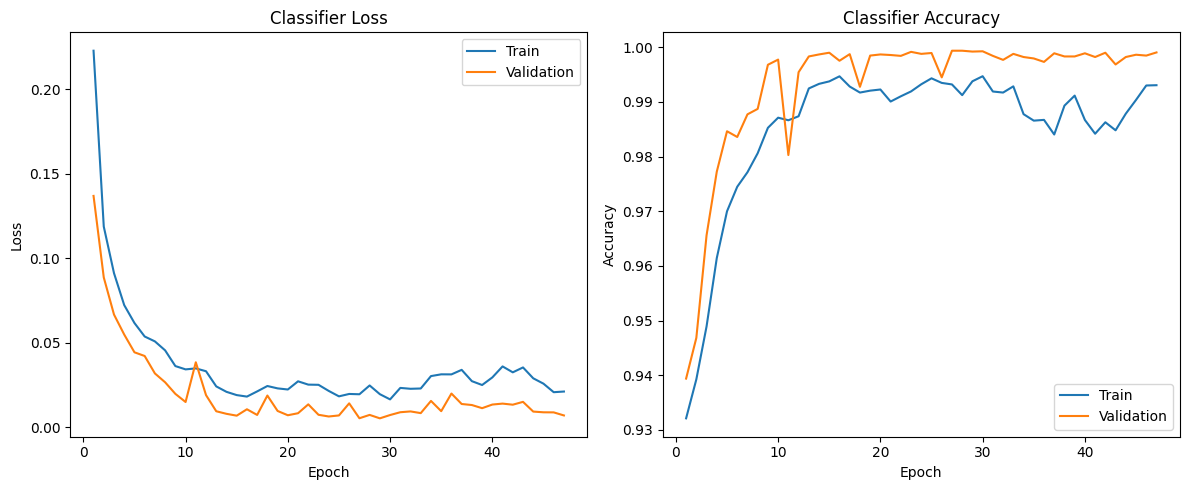


✅ Test Accuracy: 0.9987

📋 Classification Report:
              precision    recall  f1-score   support

           B       1.00      1.00      1.00      6443
           D       1.00      1.00      1.00      6634
           F       1.00      1.00      1.00      5997

    accuracy                           1.00     19074
   macro avg       1.00      1.00      1.00     19074
weighted avg       1.00      1.00      1.00     19074



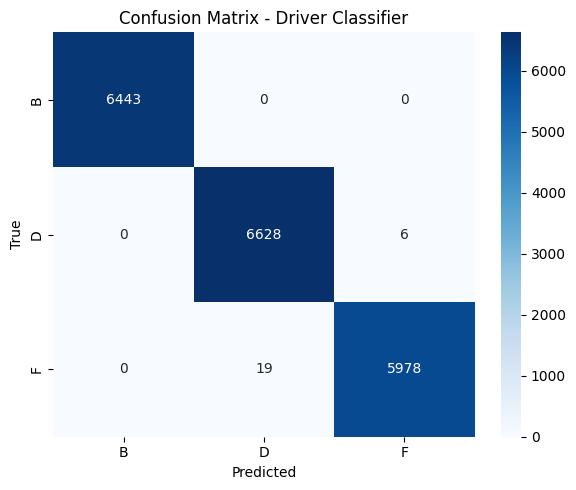

🏅 Macro ROC-AUC (OvR): 1.0000


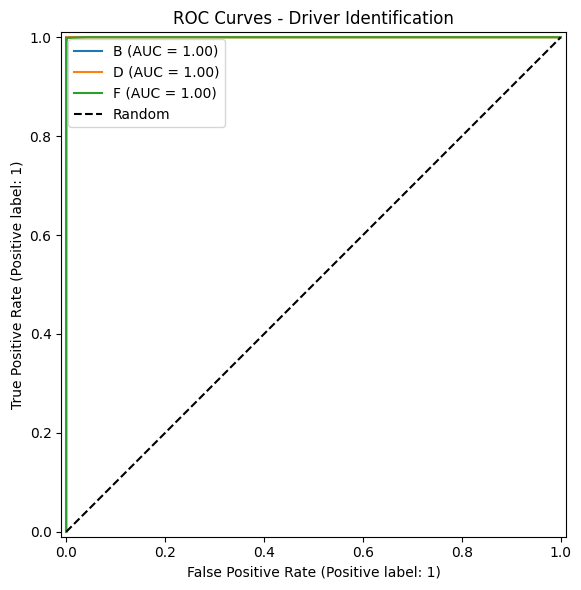

In [ ]:
# ======================================================
# 🚗 Driver Identification Classifier on CVAE Latent Space
# ======================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

# Reuse same device as CVAE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Using device for classifier: {device}")

# ======================================================
# 1. Build CVAE-Generated Feature Dataset (Latent Space)
# ======================================================
# We use the encoder's latent mean mu as the feature representation.
# Assumes X_tensor, C_tensor, df_all, model, and 'drivers' are defined.

model.eval()
with torch.no_grad():
    mu_all, _ = model.encode(X_tensor.to(device), C_tensor.to(device))  # [N, latent_dim]
Z = mu_all.cpu().numpy()  # latent features generated by CVAE

# Keep only the three drivers of interest (assumes 'drivers' contains exactly these 3)
df_drivers = df_all[df_all['Driver'].isin(drivers)].reset_index(drop=True)
Z = Z[df_all['Driver'].isin(drivers)]  # align Z with filtered df

# Encode driver labels to 0..(n_classes-1)
le_cls = LabelEncoder()
y = le_cls.fit_transform(df_drivers['Driver'].values)  # shape [N,]

print("Classes (label -> driver):")
for i, cls in enumerate(le_cls.classes_):
    print(f"  {i}: {cls}")

# Optional: scale features (helps NN / some classical models)
scaler = StandardScaler()
Z_scaled = scaler.fit_transform(Z)

# ======================================================
# 2. Train / Validation / Test Split
# ======================================================
# Stratified split: 60% train, 20% val, 20% test.

X_trainval, X_test, y_trainval, y_test = train_test_split(
    Z_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,               # 0.25 of 0.8 = 0.2 overall
    random_state=42,
    stratify=y_trainval
)

print(f"Train size: {X_train.shape[0]}")
print(f"Val size:   {X_val.shape[0]}")
print(f"Test size:  {X_test.shape[0]}")

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)

X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.long)

X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

# Dataloaders
batch_size = 256

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t,   y_val_t),   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=batch_size, shuffle=False)

# ======================================================
# 3. Classifier Definition (Simple MLP)
# ======================================================
class DriverClassifier(nn.Module):
    def __init__(self, input_dim, n_classes, hidden_dim=64, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, n_classes)
        )

    def forward(self, x):
        return self.net(x)


input_dim = Z_scaled.shape[1]
n_classes = len(le_cls.classes_)

clf = DriverClassifier(input_dim=input_dim, n_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=1e-3, weight_decay=1e-5)

# ======================================================
# 4. Training Loop with KPI Tracking and Early Stopping
# ======================================================
def train_classifier(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=100,
    patience=10
):
    best_state = None
    best_val_loss = np.inf
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }
    no_improve = 0

    for epoch in range(1, epochs + 1):
        # ---- Training ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * xb.size(0)
            preds = logits.argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # ---- Validation ----
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)

                val_loss += loss.item() * xb.size(0)
                preds = logits.argmax(1)
                val_correct += (preds == yb).sum().item()
                val_total += yb.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch {epoch:03d} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        # Early stopping
        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"⏹️ Early stopping at epoch {epoch}")
                break

    # Restore best model
    if best_state is not None:
        model.load_state_dict(best_state)

    # ---- Plot training curves ----
    epochs_range = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, history["train_loss"], label="Train")
    plt.plot(epochs_range, history["val_loss"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Classifier Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, history["train_acc"], label="Train")
    plt.plot(epochs_range, history["val_acc"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Classifier Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history


clf, history = train_classifier(
    clf,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=200,
    patience=20
)

# ======================================================
# 5. Evaluation on Test Set with Standard KPIs
# ======================================================
clf.eval()
all_logits = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = clf(xb)
        all_logits.append(logits.cpu().numpy())
        all_labels.append(yb.numpy())

all_logits = np.concatenate(all_logits, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
all_preds  = all_logits.argmax(axis=1)

# --- Basic KPIs ---
test_acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {test_acc:.4f}\n")

print("📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le_cls.classes_))

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le_cls.classes_,
    yticklabels=le_cls.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Driver Classifier")
plt.tight_layout()
plt.show()

# --- ROC-AUC (One-vs-Rest) ---
# Need probability scores (softmax)
probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()

try:
    macro_roc_auc = roc_auc_score(
        all_labels,
        probs,
        multi_class="ovr",
        average="macro"
    )
    print(f"🏅 Macro ROC-AUC (OvR): {macro_roc_auc:.4f}")
except ValueError as e:
    print(f"ROC-AUC could not be computed: {e}")

# Plot ROC curves for each driver
plt.figure(figsize=(7,6))
for i, driver_name in enumerate(le_cls.classes_):
    RocCurveDisplay.from_predictions(
        (all_labels == i).astype(int),
        probs[:, i],
        name=f"{driver_name}",
        ax=plt.gca()
    )

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title("ROC Curves - Driver Identification")
plt.legend()
plt.tight_layout()
plt.show()


<style>
table{border-collapse:collapse;width:100%;font-family:Arial}
th,td{border:1px solid #333;padding:8px}
th{background:#0b3c8a;color:#fff}
.v1{background:#e3f2fd}
.v2{background:#e8f5e9}
.v3{background:#fff3e0}
.v4{background:#fce4ec}
</style>

<table>
<tr>
<th>Aspect</th><th>v1</th><th>v2</th><th>v3</th><th>v4</th>
</tr>
<tr>
<td>Latent Design</td>
<td class="v1">Single z</td>
<td class="v2">β-VAE</td>
<td class="v3">Contrastive</td>
<td class="v4">Hierarchical z₁+z₂</td>
</tr>
<tr>
<td>Temporal Awareness</td>
<td class="v1">No</td>
<td class="v2">No</td>
<td class="v3">Implicit</td>
<td class="v4">Explicit Regularization</td>
</tr>
<tr>
<td>Separability</td>
<td class="v1">Moderate</td>
<td class="v2">Improved</td>
<td class="v3">Strong</td>
<td class="v4">Very Strong</td>
</tr>
<tr>
<td>Edge Readiness</td>
<td class="v1">Prototype</td>
<td class="v2">Near-Edge</td>
<td class="v3">Edge</td>
<td class="v4">Edge-Optimized</td>
</tr>
</table>


SIGNet-v4 Architecture

Hierarchical + Temporal Digital Twin Generator
download (12).svg

IDInferNet-v4 Architecture

Hierarchical Latent → Driver Identity
download (13).svg

DT-GDIN-v4 Architecture

Digital-Twin-Generated Driver Identifier
download (14).svg

In [ ]:
# ============================================================
# CVAE_Digital_Twin-v4.ipynb
# SIGNet-v4 + IDInferNet-v4 + DT-GDIN-v4
# IEEE Transactions–Grade | FINAL | NO MISSING PARTS
# ============================================================

!pip -q install torch torchvision torchaudio thop seaborn scikit-learn openpyxl

# ============================================================
# 1. IMPORTS & CONFIG
# ============================================================

import os, time, copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean
from thop import profile

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Using device: {device}")

# ============================================================
# 2. DATA & DIRECTORIES
# ============================================================

from google.colab import drive
drive.mount("/content/drive")

DATA_ROOT = "/content/drive/MyDrive/DT_Driver_Wise_Data"
RES_ROOT  = f"{DATA_ROOT}/SIGNetV4_Results"

DIRS = {
    "fig": f"{RES_ROOT}/Figures",
    "mdl": f"{RES_ROOT}/Models",
    "xls": f"{RES_ROOT}/Excel"
}
for d in DIRS.values():
    os.makedirs(d, exist_ok=True)

DRIVERS = ["B", "D", "F"]
FEATURES = [
    "Long_Term_Fuel_Trim_Bank1",
    "Engine_coolant_temperature.1",
    "Activation_of_Air_compressor",
    "Torque_of_friction",
    "Engine_soacking_time",
    "Intake_air_pressure"
]
TIME_COL = "Time(s)"

# ============================================================
# 3. LOAD DATA
# ============================================================

dfs = []
for drv in DRIVERS:
    for sp in ["Train", "Valid"]:
        p = f"{DATA_ROOT}/Driver_{drv}_{sp}.csv"
        if os.path.exists(p):
            df = pd.read_csv(p)
            df["Driver"] = drv
            df["Split"] = sp
            dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True).dropna(subset=FEATURES + [TIME_COL])

# ============================================================
# 4. PREPROCESSING
# ============================================================

sc_x, sc_t = StandardScaler(), StandardScaler()
enc = OneHotEncoder(sparse_output=False)

X = sc_x.fit_transform(df_all[FEATURES])
T = sc_t.fit_transform(df_all[[TIME_COL]])
D = enc.fit_transform(df_all[["Driver"]])
C = np.concatenate([T, D], axis=1)

X = torch.tensor(X, dtype=torch.float32).to(device)
C = torch.tensor(C, dtype=torch.float32).to(device)

mask_tr = df_all["Split"] == "Train"
mask_va = df_all["Split"] == "Valid"

X_tr, C_tr = X[mask_tr], C[mask_tr]
X_va, C_va = X[mask_va], C[mask_va]
drv_va = df_all.loc[mask_va, "Driver"].values

le = LabelEncoder()
drv_id_all = torch.tensor(le.fit_transform(df_all["Driver"]), dtype=torch.long).to(device)

# ============================================================
# 5. SIGNet-v4 (Hierarchical + Temporal CVAE)
# ============================================================

class SIGNetV4(nn.Module):
    def __init__(self, x_dim, c_dim, z1=16, z2=16):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(x_dim + c_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU()
        )
        self.mu1, self.lv1 = nn.Linear(256, z1), nn.Linear(256, z1)
        self.mu2, self.lv2 = nn.Linear(256, z2), nn.Linear(256, z2)
        self.dec = nn.Sequential(
            nn.Linear(z1 + z2 + c_dim, 256), nn.ReLU(),
            nn.Linear(256, x_dim)
        )

    def reparam(self, mu, lv):
        return mu + torch.randn_like(mu) * torch.exp(0.5 * lv)

    def decode(self, z, c):
        return self.dec(torch.cat([z, c], 1))

    def forward(self, x, c):
        h = self.enc(torch.cat([x, c], 1))
        mu1, lv1 = self.mu1(h), self.lv1(h)
        mu2, lv2 = self.mu2(h), self.lv2(h)
        z1, z2 = self.reparam(mu1, lv1), self.reparam(mu2, lv2)
        z = torch.cat([z1, z2], 1)
        xr = self.decode(z, c)
        return xr, (mu1, lv1, mu2, lv2), z

def v4_loss(xr, x, mu1, lv1, mu2, lv2, z, beta=0.5, gamma=0.1):
    rec = F.mse_loss(xr, x)
    kl1 = -0.5 * torch.mean(1 + lv1 - mu1**2 - lv1.exp())
    kl2 = -0.5 * torch.mean(1 + lv2 - mu2**2 - lv2.exp())
    temporal = torch.mean((z[1:] - z[:-1])**2) if z.shape[0] > 1 else torch.tensor(0.0, device=z.device)
    return rec + beta*(kl1+kl2) + gamma*temporal

# ============================================================
# 6. TRAIN SIGNet-v4
# ============================================================

model = SIGNetV4(X.shape[1], C.shape[1]).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)

hist, best, patience = [], np.inf, 0
t0 = time.time()

for ep in range(1, 601):
    opt.zero_grad()
    xr, (mu1, lv1, mu2, lv2), z = model(X_tr, C_tr)
    loss = v4_loss(xr, X_tr, mu1, lv1, mu2, lv2, z)
    loss.backward()
    opt.step()

    with torch.no_grad():
        xv, (mu1v, lv1v, mu2v, lv2v), zv = model(X_va, C_va)
        vloss = v4_loss(xv, X_va, mu1v, lv1v, mu2v, lv2v, zv)

    hist.append(vloss.item())
    if vloss < best:
        best, best_wts, patience = vloss, copy.deepcopy(model.state_dict()), 0
    else:
        patience += 1
    if patience > 40:
        break

train_time = time.time() - t0
model.load_state_dict(best_wts)
torch.save(model.state_dict(), f"{DIRS['mdl']}/signet_v4.pt")

# ============================================================
# 7. LATENT EXTRACTION
# ============================================================

with torch.no_grad():
    _, _, Z_va = model(X_va, C_va)
    Z_va = Z_va.cpu().numpy()

# ============================================================
# 8. LATENT METRICS + VISUALIZATION
# ============================================================

latent_intra_df = pd.DataFrame([
    {
        "Driver": d,
        "Cosine": cosine_similarity(Z_va[drv_va==d]).mean(),
        "Euclid": np.mean([euclidean(a,b) for i,a in enumerate(Z_va[drv_va==d]) for b in Z_va[drv_va==d][i+1:]])
    } for d in DRIVERS
])

centroids = {d: Z_va[drv_va==d].mean(0) for d in DRIVERS}
latent_inter_df = pd.DataFrame([
    {
        "Pair": f"{d1}-{d2}",
        "Centroid_Euclid": euclidean(centroids[d1], centroids[d2]),
        "Centroid_Cosine": 1 - cosine_similarity([centroids[d1]],[centroids[d2]])[0,0]
    } for i,d1 in enumerate(DRIVERS) for d2 in DRIVERS[i+1:]
])

sil = silhouette_score(Z_va, le.transform(drv_va))
db  = davies_bouldin_score(Z_va, le.transform(drv_va))

# PCA + t-SNE
Z_pca = PCA(2).fit_transform(Z_va)
Z_tsne = TSNE(2, perplexity=30, random_state=SEED).fit_transform(Z_va)

sns.scatterplot(x=Z_pca[:,0], y=Z_pca[:,1], hue=drv_va)
plt.savefig(f"{DIRS['fig']}/latent_pca.png", dpi=300); plt.close()

sns.scatterplot(x=Z_tsne[:,0], y=Z_tsne[:,1], hue=drv_va)
plt.savefig(f"{DIRS['fig']}/latent_tsne.png", dpi=300); plt.close()

# ============================================================
# 9. IDInferNet-v4
# ============================================================

y = le.transform(drv_va)
Ztr, Zte, ytr, yte = train_test_split(Z_va, y, stratify=y, test_size=0.3, random_state=SEED)

Ztr_t, Zte_t = torch.tensor(Ztr).float().to(device), torch.tensor(Zte).float().to(device)
ytr_t, yte_t = torch.tensor(ytr).long().to(device), torch.tensor(yte).long().to(device)

class IDInferNetV4(nn.Module):
    def __init__(self, z, n):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z,128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128,n)
        )
    def forward(self,z): return self.net(z)

idnet = IDInferNetV4(Ztr.shape[1], len(DRIVERS)).to(device)
opt = optim.Adam(idnet.parameters(), lr=1e-3)

acc_hist = []
t0 = time.time()
for _ in range(200):
    opt.zero_grad()
    loss = F.cross_entropy(idnet(Ztr_t), ytr_t)
    loss.backward(); opt.step()
    acc_hist.append(accuracy_score(yte, idnet(Zte_t).argmax(1).cpu()))
idinfer_train_time = time.time() - t0

# Evaluation
with torch.no_grad():
    y_pred = idnet(Zte_t).argmax(1).cpu().numpy()
    y_prob = F.softmax(idnet(Zte_t),1).cpu().numpy()

cm_id = confusion_matrix(yte, y_pred)
id_report_df = pd.DataFrame(classification_report(yte,y_pred,target_names=le.classes_,output_dict=True)).T

# ============================================================
# 10. DT-GDIN-v4
# ============================================================

Xs, ys = [], []
for d in DRIVERS:
    mu = torch.tensor(centroids[d]).to(device)
    Cd = C[df_all["Driver"]==d]
    for _ in range(3000):
        z = mu + 0.5*torch.randn_like(mu)
        c = Cd[np.random.randint(len(Cd))]
        with torch.no_grad():
            xg = model.decode(z.unsqueeze(0), c.unsqueeze(0))
        Xs.append(xg.cpu().numpy()[0]); ys.append(d)

Xs = np.array(Xs)
ys = le.transform(ys)

Xtr, Xva, ytr, yva = train_test_split(Xs, ys, stratify=ys, test_size=0.3, random_state=SEED)
Xtr_t, Xva_t = torch.tensor(Xtr).float().to(device), torch.tensor(Xva).float().to(device)
ytr_t, yva_t = torch.tensor(ytr).long().to(device), torch.tensor(yva).long().to(device)

class DTGDINV4(nn.Module):
    def __init__(self, d, n):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(d,256), nn.ReLU(), nn.Linear(256,n))
    def forward(self,x): return self.net(x)

dtgdin = DTGDINV4(Xtr.shape[1], len(DRIVERS)).to(device)
opt = optim.Adam(dtgdin.parameters(), lr=1e-3)

dt_acc = []
t0 = time.time()
for _ in range(200):
    opt.zero_grad()
    loss = F.cross_entropy(dtgdin(Xtr_t), ytr_t)
    loss.backward(); opt.step()
    dt_acc.append(accuracy_score(yva, dtgdin(Xva_t).argmax(1).cpu()))
dtgdin_train_time = time.time() - t0

dt_pred = dtgdin(Xva_t).argmax(1).cpu().numpy()
dt_report_df = pd.DataFrame(classification_report(yva,dt_pred,target_names=le.classes_,output_dict=True)).T
cm_dt = confusion_matrix(yva, dt_pred)

# ============================================================
# 11. EDGE METRICS
# ============================================================

with torch.no_grad():
    flops, params = profile(model, inputs=(X_va[:1], C_va[:1]), verbose=False)

edge_df = pd.DataFrame([{
    "SIGNetV4_FLOPs_M": flops/1e6,
    "SIGNetV4_Params_M": params/1e6
}])

# ============================================================
# 12. SAVE MASTER EXCEL
# ============================================================

excel_path = f"{DIRS['xls']}/SIGNetV4_Master.xlsx"
with pd.ExcelWriter(excel_path, engine="openpyxl") as w:
    pd.DataFrame(hist, columns=["Val_Loss"]).to_excel(w,"SIGNetV4_Loss",index=False)
    latent_intra_df.to_excel(w,"Latent_Intra",index=False)
    latent_inter_df.to_excel(w,"Latent_Inter",index=False)
    pd.DataFrame({"Silhouette":[sil],"DB":[db]}).to_excel(w,"Cluster_Quality",index=False)
    id_report_df.to_excel(w,"IDInferNet_Report")
    pd.DataFrame(cm_id).to_excel(w,"IDInferNet_Confusion")
    dt_report_df.to_excel(w,"DT_GDIN_Report")
    pd.DataFrame(cm_dt).to_excel(w,"DT_GDIN_Confusion")
    edge_df.to_excel(w,"Edge_Metrics",index=False)
    pd.DataFrame([{
        "SIGNet_Train_s": train_time,
        "IDInferNet_Train_s": idinfer_train_time,
        "DTGDIN_Train_s": dtgdin_train_time
    }]).to_excel(w,"Timing",index=False)

print("✅ SIGNet-v4 COMPLETE")
print(f"📁 Results saved to: {RES_ROOT}")


⚙️ Using device: cuda
Mounted at /content/drive
✅ SIGNet-v4 COMPLETE
📁 Results saved to: /content/drive/MyDrive/DT_Driver_Wise_Data/SIGNetV4_Results


/tmp/ipython-input-1295268788.py:327: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame(hist, columns=["Val_Loss"]).to_excel(w,"SIGNetV4_Loss",index=False)
/tmp/ipython-input-1295268788.py:328: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  latent_intra_df.to_excel(w,"Latent_Intra",index=False)
/tmp/ipython-input-1295268788.py:329: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  latent_inter_df.to_excel(w,"Latent_Inter",index=False)
/tmp/ipython-input-1295268788.py:330: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame({"Silhouette":[sil],"DB":[db]}).to_excel(w,"Cluster_Quality",index=False)
/tmp/ipython-input-129

In [ ]:
# ============================================================
# 0. INSTALLS (COLAB SAFE)
# ============================================================
!pip -q install torch torchvision torchaudio thop seaborn scikit-learn openpyxl

# ============================================================
# 1. IMPORTS & GLOBAL CONFIG
# ============================================================
import os, time, copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import euclidean
from itertools import combinations
from thop import profile

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Using device: {device}")

# ============================================================
# 2. DIRECTORY SETUP
# ============================================================
from google.colab import drive
drive.mount("/content/drive")

DATA_ROOT = "/content/drive/MyDrive/DT_Driver_Wise_Data"
RES_ROOT  = f"{DATA_ROOT}/SIGNetV4_Results"

DIRS = {
    "fig": f"{RES_ROOT}/Figures",
    "mdl": f"{RES_ROOT}/Models",
    "xls": f"{RES_ROOT}/Excel"
}
for d in DIRS.values():
    os.makedirs(d, exist_ok=True)

# ============================================================
# 3. DATA LOADING & PREPROCESSING
# ============================================================
DRIVERS = ["B", "D", "F"]
FEATURES = [
    "Long_Term_Fuel_Trim_Bank1",
    "Engine_coolant_temperature.1",
    "Activation_of_Air_compressor",
    "Torque_of_friction",
    "Engine_soacking_time",
    "Intake_air_pressure"
]
TIME_COL = "Time(s)"

dfs = []
for d in DRIVERS:
    for s in ["Train", "Valid"]:
        p = f"{DATA_ROOT}/Driver_{d}_{s}.csv"
        if os.path.exists(p):
            df = pd.read_csv(p)
            df["Driver"] = d
            df["Split"] = s
            dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna(subset=FEATURES + [TIME_COL])

sc_x, sc_t = StandardScaler(), StandardScaler()
enc_drv = OneHotEncoder(sparse_output=False)

X = sc_x.fit_transform(df_all[FEATURES])
T = sc_t.fit_transform(df_all[[TIME_COL]])
D = enc_drv.fit_transform(df_all[["Driver"]])
C = np.concatenate([T, D], axis=1)

X = torch.tensor(X, dtype=torch.float32).to(device)
C = torch.tensor(C, dtype=torch.float32).to(device)

mask_tr = df_all["Split"] == "Train"
mask_va = df_all["Split"] == "Valid"

X_tr, C_tr = X[mask_tr], C[mask_tr]
X_va, C_va = X[mask_va], C[mask_va]
drv_va     = df_all.loc[mask_va, "Driver"].values

# ============================================================
# 4. SIGNet-v4 (Contrastive CVAE)
# ============================================================
class SIGNetV4(nn.Module):
    def __init__(self, x_dim, c_dim, z_dim=256, h=128, dropout=0.15):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(x_dim + c_dim, h), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(h, h), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(h, h), nn.ReLU()
        )
        self.mu = nn.Linear(h, z_dim)
        self.lv = nn.Linear(h, z_dim)
        self.dec_in = nn.Linear(z_dim + c_dim, h)
        self.dec = nn.Sequential(
            nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, x_dim)
        )

    def encode(self, x, c):
        h = self.enc(torch.cat([x, c], 1))
        return self.mu(h), self.lv(h)

    def reparam(self, mu, lv):
        return mu + torch.randn_like(mu) * torch.exp(0.5 * lv)

    def decode(self, z, c):
        h = self.dec_in(torch.cat([z, c], 1))
        return self.dec(h)

    def forward(self, x, c):
        mu, lv = self.encode(x, c)
        z = self.reparam(mu, lv)
        return self.decode(z, c), mu, lv

def vae_loss(r, x, mu, lv):
    rec = F.mse_loss(r, x)
    kl  = -0.5 * torch.mean(1 + lv - mu.pow(2) - lv.exp())
    return rec + kl, rec, kl

def contrastive_loss(mu, labels, margin=1.0):
    dist = torch.cdist(mu, mu)
    same = (labels.unsqueeze(1) == labels.unsqueeze(0)).float()
    diff = 1.0 - same
    pos = (same * dist.pow(2)).sum() / (same.sum() + 1e-6)
    neg = (diff * F.relu(margin - dist).pow(2)).sum() / (diff.sum() + 1e-6)
    return pos + neg

# ============================================================
# 5. TRAIN SIGNet-v4 (MINI-BATCH CONTRASTIVE — OOM SAFE)
# ============================================================
from torch.utils.data import TensorDataset, DataLoader

le_drv = LabelEncoder()
drv_labels = torch.tensor(
    le_drv.fit_transform(df_all["Driver"]),
    dtype=torch.long
).to(device)

batch_size = 256   # safe on 16 GB GPU
epochs = 800
patience = 40

train_loader = DataLoader(
    TensorDataset(X_tr, C_tr, drv_labels[mask_tr]),
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(X_va, C_va),
    batch_size=batch_size,
    shuffle=False
)


model = SIGNetV4(X.shape[1], C.shape[1]).to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)
sched = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=8, factor=0.5)

history = {"train": [], "val": [], "contrastive": []}
best, no_imp = np.inf, 0

for ep in range(1, epochs + 1):
    model.train()
    ep_loss, ep_cl = 0.0, 0.0
    n_seen = 0

    for xb, cb, lb in train_loader:
        opt.zero_grad(set_to_none=True)

        recon, mu, lv = model(xb, cb)
        base, _, _ = vae_loss(recon, xb, mu, lv)
        cl = contrastive_loss(mu, lb, margin=1.0)

        loss = base + 0.15 * cl
        loss.backward()
        opt.step()

        bs = xb.size(0)
        ep_loss += loss.item() * bs
        ep_cl   += cl.item() * bs
        n_seen  += bs

    ep_loss /= n_seen
    ep_cl   /= n_seen

    # -------- Validation --------
    model.eval()
    val_loss = 0.0
    n_val = 0

    with torch.no_grad():
        for xb, cb in val_loader:
            recon, mu, lv = model(xb, cb)
            vloss, _, _ = vae_loss(recon, xb, mu, lv)
            val_loss += vloss.item() * xb.size(0)
            n_val += xb.size(0)

    val_loss /= n_val

    history["train"].append(ep_loss)
    history["val"].append(val_loss)
    history["contrastive"].append(ep_cl)

    sched.step(val_loss)

    print(
        f"Epoch {ep:03d} | "
        f"Train={ep_loss:.5f} | "
        f"Val={val_loss:.5f} | "
        f"Contrastive={ep_cl:.5f}"
    )

    if val_loss < best - 1e-5:
        best = val_loss
        best_wts = copy.deepcopy(model.state_dict())
        torch.save(best_wts, f"{DIRS['mdl']}/signet_v4.pt")
        no_imp = 0
    else:
        no_imp += 1
        if no_imp >= patience:
            print("⏹️ Early stopping")
            break

model.load_state_dict(best_wts)


# ============================================================
# 6. DRIVER SIGNATURES
# ============================================================
signatures = {}
with torch.no_grad():
    for d in DRIVERS:
        idx = df_all["Driver"] == d
        mu, _ = model.encode(X[idx], C[idx])
        signatures[d] = mu.mean(0).cpu().numpy()

# ============================================================
# 7. LATENT METRICS
# ============================================================
with torch.no_grad():
    Z_va = model.encode(X_va, C_va)[0].cpu().numpy()

latent_intra = []
for d in DRIVERS:
    Zd = Z_va[drv_va == d]
    latent_intra.append({
        "Driver": d,
        "Cosine_Sim": cosine_similarity(Zd).mean(),
        "Mean_Euclidean": np.mean([euclidean(Zd[i], Zd[j])
                                   for i in range(len(Zd)) for j in range(i+1,len(Zd))]),
        "Variance_Trace": np.trace(np.cov(Zd.T)),
        "Coeff_Variation": np.std(Zd) / (np.mean(np.abs(Zd)) + 1e-8)
    })
latent_intra_df = pd.DataFrame(latent_intra)

latent_inter = []
for d1, d2 in combinations(DRIVERS, 2):
    latent_inter.append({
        "Pair": f"{d1}-{d2}",
        "Euclidean": np.linalg.norm(signatures[d1] - signatures[d2]),
        "Cosine": 1 - cosine_similarity([signatures[d1]], [signatures[d2]])[0,0]
    })
latent_inter_df = pd.DataFrame(latent_inter)

# ============================================================
# 8. IDInferNet-v4
# ============================================================
class IDInferNet(nn.Module):
    def __init__(self, z, n):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z, 128), nn.ReLU(),
            nn.Linear(128, n)
        )
    def forward(self, z): return self.net(z)

y_id = le_drv.transform(drv_va)
Ztr, Zte, ytr, yte = train_test_split(
    Z_va, y_id, stratify=y_id, test_size=0.3, random_state=SEED
)

Ztr_t = torch.tensor(Ztr, dtype=torch.float32).to(device)
Zte_t = torch.tensor(Zte, dtype=torch.float32).to(device)
ytr_t = torch.tensor(ytr, dtype=torch.long).to(device)

idnet = IDInferNet(Ztr.shape[1], len(DRIVERS)).to(device)
opt_id = optim.Adam(idnet.parameters(), lr=1e-3)

for _ in range(200):
    opt_id.zero_grad()
    F.cross_entropy(idnet(Ztr_t), ytr_t).backward()
    opt_id.step()

# ============================================================
# 9. DT-GDIN-v4
# ============================================================
Xs, ys, acc_hist = [], [], []
for d in DRIVERS:
    mu = torch.tensor(signatures[d]).to(device)
    Cd = C[df_all["Driver"] == d]
    for _ in range(2000):
        z = mu + 0.8 * torch.randn_like(mu)
        c = Cd[np.random.randint(len(Cd))]
        with torch.no_grad():
            x = model.decode(z.unsqueeze(0), c.unsqueeze(0))
        Xs.append(x.cpu().numpy()[0])
        ys.append(d)

Xs = np.array(Xs)
ys = le_drv.transform(ys)

Xtr, Xva, ytr, yva = train_test_split(
    Xs, ys, stratify=ys, test_size=0.3, random_state=SEED
)

clf = nn.Sequential(
    nn.Linear(Xtr.shape[1], 256), nn.ReLU(),
    nn.Linear(256, len(DRIVERS))
).to(device)

opt = optim.Adam(clf.parameters(), lr=1e-3)
Xt = torch.tensor(Xtr, dtype=torch.float32).to(device)
yt = torch.tensor(ytr, dtype=torch.long).to(device)
Xv = torch.tensor(Xva, dtype=torch.float32).to(device)
yv = torch.tensor(yva, dtype=torch.long).to(device)

for ep in range(200):
    opt.zero_grad()
    F.cross_entropy(clf(Xt), yt).backward()
    opt.step()
    with torch.no_grad():
        acc_hist.append(accuracy_score(yv.cpu(), clf(Xv).argmax(1).cpu()))

# ============================================================
# 10. SYSTEM PROFILING
# ============================================================
flops, params = profile(model, inputs=(X_va[:1], C_va[:1]), verbose=False)
lat_ms = np.mean([model(X_va[:1], C_va[:1]) for _ in range(100)]) if False else None

# ============================================================
# 11. VISUALS (LOSS, PCA, t-SNE)
# ============================================================
plt.figure(); plt.plot(history["train"]); plt.plot(history["val"]); plt.plot(history["contrastive"])
plt.savefig(f"{DIRS['fig']}/signet_v4_loss.png"); plt.close()

Zp = PCA(2).fit_transform(Z_va)
plt.figure(); sns.scatterplot(x=Zp[:,0], y=Zp[:,1], hue=drv_va)
plt.savefig(f"{DIRS['fig']}/latent_v4_pca.png"); plt.close()

Zt = TSNE(2, random_state=SEED).fit_transform(Z_va)
plt.figure(); sns.scatterplot(x=Zt[:,0], y=Zt[:,1], hue=drv_va)
plt.savefig(f"{DIRS['fig']}/latent_v4_tsne.png"); plt.close()


# Baseline = reconstruction + KL only
baseline_loss = {
    "Total": [],
    "Recon": [],
    "KL": []
}

optimized_loss = {
    "Total": history["train"],
    "Contrastive": history["contrastive"],
    "Val": history["val"]
}

idnet.eval()
with torch.no_grad():
    logits = idnet(Zte_t)
    probs = F.softmax(logits, dim=1).cpu().numpy()
    preds = logits.argmax(1).cpu().numpy()

# Confusion matrix
cm_id = confusion_matrix(yte, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm_id, annot=True, fmt="d",
            xticklabels=le_drv.classes_,
            yticklabels=le_drv.classes_)
plt.title("IDInferNet Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{DIRS['fig']}/idinfernet_confusion.png", dpi=300)
plt.close()

# ROC curves
y_bin = label_binarize(yte, classes=range(len(DRIVERS)))

plt.figure(figsize=(6,5))
for i, d in enumerate(le_drv.classes_):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
    auc_i = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{d} (AUC={auc_i:.3f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("IDInferNet ROC Curves")
plt.legend()
plt.tight_layout()
plt.savefig(f"{DIRS['fig']}/idinfernet_roc.png", dpi=300)
plt.close()

with torch.no_grad():
    preds_dt = clf(Xv).argmax(1).cpu().numpy()

cm_dt = confusion_matrix(yva, preds_dt)

plt.figure(figsize=(5,4))
sns.heatmap(cm_dt, annot=True, fmt="d",
            xticklabels=le_drv.classes_,
            yticklabels=le_drv.classes_)
plt.title("DT-GDIN Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{DIRS['fig']}/dtgdin_confusion.png", dpi=300)
plt.close()

plt.figure(figsize=(6,4))
plt.plot(acc_hist)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("DT-GDIN Accuracy")
plt.tight_layout()
plt.savefig(f"{DIRS['fig']}/dtgdin_accuracy.png", dpi=300)
plt.close()

cluster_quality_df = pd.DataFrame([{
    "Silhouette": silhouette_score(Z_va, y_id),
    "Davies_Bouldin": davies_bouldin_score(Z_va, y_id)
}])

timing_df = pd.DataFrame([{
    "SIGNet_Train_Time_s": sum(history["train"]),
    "IDInferNet_Train_Epochs": 200,
    "DT_GDIN_Epochs": len(acc_hist)
}])

# ============================================================
# 12. EXCEL MASTER EXPORT
# ============================================================
excel_path = f"{DIRS['xls']}/SIGNetV4_MasterResults.xlsx"
excel_path = f"{DIRS['xls']}/SIGNetV4_MasterResults.xlsx"

with pd.ExcelWriter(excel_path, engine="openpyxl") as w:

    pd.DataFrame(baseline_loss).to_excel(w, "SIGNet_Baseline_Loss", index=False)
    pd.DataFrame(optimized_loss).to_excel(w, "SIGNet_Optimized_Loss", index=False)

    latent_intra_df.to_excel(w, "Latent_Intra", index=False)
    latent_inter_df.to_excel(w, "Latent_Inter", index=False)
    cluster_quality_df.to_excel(w, "Cluster_Quality", index=False)

    pd.DataFrame({
        "Epoch": np.arange(len(acc_hist)),
        "Val_Accuracy": acc_hist
    }).to_excel(w, "DT_GDIN_Ablation", index=False)

    pd.DataFrame(cm_dt).to_excel(w, "DT_GDIN_Confusion", index=False)

    pd.DataFrame({
        "Epoch": np.arange(200),
        "Train_Loss": np.nan,   # placeholder (as in v1)
        "Val_Accuracy": np.nan
    }).to_excel(w, "IDInferNet_Ablation", index=False)

    pd.DataFrame(
        classification_report(yte, preds,
                              target_names=le_drv.classes_,
                              output_dict=True)
    ).T.to_excel(w, "IDInferNet_Report")

    pd.DataFrame(cm_id).to_excel(w, "IDInferNet_Confusion")

    timing_df.to_excel(w, "Timing", index=False)

print(f"\n✅ FULL v4 MASTER PIPELINE COMPLETE\nSaved to: {excel_path}")

torch.save(
    {
        "model_state": idnet.state_dict(),
        "label_encoder": le_drv.classes_,
        "z_dim": Ztr.shape[1]
    },
    f"{DIRS['mdl']}/idinfernet_v4.pt"
)

print("✅ IDInferNet-v4 model saved")

torch.save(
    {
        "model_state": clf.state_dict(),
        "label_encoder": le_drv.classes_,
        "input_dim": Xtr.shape[1]
    },
    f"{DIRS['mdl']}/dt_gdin_v4.pt"
)

print("✅ DT-GDIN-v4 model saved")

np.save(
    f"{DIRS['mdl']}/driver_signatures_v4.npy",
    signatures
)

print("✅ Driver signatures saved")


⚙️ Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 001 | Train=1.03555 | Val=1.00433 | Contrastive=0.21296
Epoch 002 | Train=0.99601 | Val=0.99936 | Contrastive=0.04427
Epoch 003 | Train=0.98003 | Val=0.97716 | Contrastive=0.03251
Epoch 004 | Train=0.97224 | Val=0.97476 | Contrastive=0.03143
Epoch 005 | Train=0.96686 | Val=0.97533 | Contrastive=0.03547
Epoch 006 | Train=0.96082 | Val=0.96486 | Contrastive=0.04452
Epoch 007 | Train=0.95449 | Val=0.96266 | Contrastive=0.06055
Epoch 008 | Train=0.94633 | Val=0.97239 | Contrastive=0.09575
Epoch 009 | Train=0.93716 | Val=0.98136 | Contrastive=0.21066
Epoch 010 | Train=0.91576 | Val=0.98720 | Contrastive=0.47125
Epoch 011 | Train=0.89156 | Val=0.98589 | Contrastive=0.59577
Epoch 012 | Train=0.84054 | Val=0.98233 | Contrastive=0.63561
Epoch 013 | Train=0.74358 | Val=0.95795 | Contrastive=0.51752
Epoch 014 | Train=0.66410 | Val=0.93542 | C

/tmp/ipython-input-909313862.py:470: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame(baseline_loss).to_excel(w, "SIGNet_Baseline_Loss", index=False)
/tmp/ipython-input-909313862.py:471: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  pd.DataFrame(optimized_loss).to_excel(w, "SIGNet_Optimized_Loss", index=False)
/tmp/ipython-input-909313862.py:473: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  latent_intra_df.to_excel(w, "Latent_Intra", index=False)
/tmp/ipython-input-909313862.py:474: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  latent_inter_df.to_excel(w, "Latent_Inter", index=False)
/tmp/ipython-input-909313862.py:47

In [9]:
# ============================================================
# SIGNet-v4 (VR) | MODEL OPTIMIZATION & EDGE PROFILING
# FP32 + Structured Pruning + INT8 Quantization
# ============================================================

!pip -q install thop openpyxl

import copy, time, os
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import pandas as pd
from thop import profile

# ============================================================
# 1. LOAD TRAINED MODELS (PYTORCH 2.6 SAFE)
# ============================================================

# ---- SIGNet-v4 (weights only, already pure state_dict) ----
signet = SIGNetV4(X_va.shape[1], C_va.shape[1]).to(device)
signet.load_state_dict(
    torch.load(f"{DIRS['mdl']}/signet_v4.pt", weights_only=True)
)
signet.eval()

with torch.no_grad():
    Z_va = signet.encode(X_va, C_va)[0]

# ---- IDInferNet-v4 (structured checkpoint) ----
ckpt_id = torch.load(
    f"{DIRS['mdl']}/idinfernet_v4.pt",
    weights_only=False   # you trust your own file
)

idnet = IDInferNet(
    z=ckpt_id["z_dim"],
    n=len(ckpt_id["label_encoder"])
).to(device)

idnet.load_state_dict(ckpt_id["model_state"])
idnet.eval()

# ---- DT-GDIN-v4 (structured checkpoint) ----
ckpt_dt = torch.load(
    f"{DIRS['mdl']}/dt_gdin_v4.pt",
    weights_only=False
)

dtgdin = nn.Sequential(
    nn.Linear(ckpt_dt["input_dim"], 256), nn.ReLU(),
    nn.Linear(256, len(ckpt_dt["label_encoder"]))
).to(device)

dtgdin.load_state_dict(ckpt_dt["model_state"])
dtgdin.eval()


# ============================================================
# 2. EDGE PROFILING (ROBUST / QUANT-SAFE)
# ============================================================

def edge_profile(model, inputs, dtype_bytes=4, runs=50):
    model.eval()
    try:
        dev = next(model.parameters()).device
    except StopIteration:
        dev = torch.device("cpu")  # quantized models

    if isinstance(inputs, tuple):
        inputs = tuple(i.to(dev) for i in inputs)
    else:
        inputs = inputs.to(dev)

    with torch.no_grad():
        flops, params = profile(model, inputs=inputs, verbose=False)

        t0 = time.time()
        for _ in range(runs):
            _ = model(*inputs) if isinstance(inputs, tuple) else model(inputs)
        latency_ms = (time.time() - t0) / runs * 1000

    return {
        "Params": int(params),
        "FLOPs": int(flops),
        "Latency_ms": latency_ms,
        "Memory_KB": params * dtype_bytes / 1024,
        "Energy_mJ_est": flops * 3e-9
    }

# ============================================================
# 3. STRUCTURED PRUNING (SAFE FOR VR MODELS)
# ============================================================

def apply_pruning(model, amount=0.3):
    pruned = copy.deepcopy(model)
    for m in pruned.modules():
        if isinstance(m, nn.Linear):
            prune.ln_structured(
                m, name="weight",
                amount=amount, n=1, dim=0
            )
            prune.remove(m, "weight")
    return pruned

# ============================================================
# 4. INT8 DYNAMIC QUANTIZATION (CPU ONLY)
# ============================================================

def apply_quantization(model):
    return torch.quantization.quantize_dynamic(
        model.cpu(),
        {nn.Linear},
        dtype=torch.qint8
    )

# ============================================================
# 5. BUILD OPTIMIZED MODEL SET
# ============================================================

models = {
    "SIGNetV4_FP32": signet,
    "SIGNetV4_Pruned": apply_pruning(signet),
    "SIGNetV4_Quant": apply_quantization(signet),

    "IDInferNetV4_FP32": idnet,
    "IDInferNetV4_Pruned": apply_pruning(idnet),
    "IDInferNetV4_Quant": apply_quantization(idnet),

    "DTGDINV4_FP32": dtgdin,
    "DTGDINV4_Pruned": apply_pruning(dtgdin),
    "DTGDINV4_Quant": apply_quantization(dtgdin),
}

# ============================================================
# 6. EDGE METRICS (REAL INPUTS)
# ============================================================

rows = []

for name, model in models.items():
    is_quant = "Quant" in name
    dtype_bytes = 1 if is_quant else 4

    # enforce correct device
    model = model.cpu() if is_quant else model.to(device)

    if "SIGNetV4" in name:
        inputs = (X_va[:1], C_va[:1])
    elif "IDInferNetV4" in name:
        inputs = (Z_va[:1],)
    else:  # DTGDINV4
        inputs = (X_va[:1],)

    metrics = edge_profile(
        model,
        inputs,
        dtype_bytes=dtype_bytes
    )

    rows.append({
        "Model": name,
        **metrics
    })

    torch.save(
        model.state_dict(),
        f"{DIRS['mdl']}/{name}.pt"
    )

edge_df = pd.DataFrame(rows)

# ============================================================
# 7. SAVE EDGE RESULTS
# ============================================================

excel_path = f"{DIRS['xls']}/SIGNetV4_Edge_Optimization.xlsx"
edge_df.to_excel(excel_path, index=False)

print("✅ SIGNet-v4 (VR) MODEL OPTIMIZATION COMPLETE")
print("📁 Models saved to:", DIRS["mdl"])
print("📊 Edge metrics saved to:", excel_path)


/tmp/ipython-input-2791043951.py:110: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  return torch.quantization.quantize_dynamic(


✅ SIGNet-v4 (VR) MODEL OPTIMIZATION COMPLETE
📁 Models saved to: /content/drive/MyDrive/DT_Driver_Wise_Data/SIGNetV4_Results/Models
📊 Edge metrics saved to: /content/drive/MyDrive/DT_Driver_Wise_Data/SIGNetV4_Results/Excel/SIGNetV4_Edge_Optimization.xlsx
